# 🥇 Gold Price Prediction - HIGH PRICE YEARS ONLY

## Strategy: Train on 2022-2025 data only (₹47k - ₹79k range)

**Why this works:**
- Model learns from recent, relevant price patterns
- No old ₹25k data confusing the predictions
- Training distribution matches prediction needs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print(f'TensorFlow: {tf.__version__}')
print('✅ Imports ready!')

TensorFlow: 2.20.0
✅ Imports ready!


## 📊 Load Data & Filter to Recent Years

In [2]:
# Load full data
df_full = pd.read_csv('Gold Price.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])
df_full = df_full.sort_values('Date').reset_index(drop=True)

print('Full dataset:')
print(f'  Range: {df_full["Date"].min().date()} to {df_full["Date"].max().date()}')
print(f'  Rows: {len(df_full)}')
print(f'  Price: ₹{df_full["Price"].min():,.0f} - ₹{df_full["Price"].max():,.0f}')

Full dataset:
  Range: 2014-01-01 to 2025-01-06
  Rows: 2848
  Price: ₹24,545 - ₹79,257


In [3]:
# ⚠️ KEY CHANGE: Filter to HIGH PRICE YEARS ONLY (2022-2025)
START_YEAR = 2022

df = df_full[df_full['Date'].dt.year >= START_YEAR].copy()
df = df[['Date', 'Price']].copy()
df.set_index('Date', inplace=True)

print(f'\n✅ FILTERED DATASET (from {START_YEAR} onwards):')
print(f'  Range: {df.index.min().date()} to {df.index.max().date()}')
print(f'  Rows: {len(df)}')
print(f'  Price: ₹{df["Price"].min():,.0f} - ₹{df["Price"].max():,.0f}')
print(f'  Mean: ₹{df["Price"].mean():,.0f}')

# This is MUCH better for predicting ₹77k+ prices!


✅ FILTERED DATASET (from 2022 onwards):
  Range: 2022-01-03 to 2025-01-06
  Rows: 774
  Price: ₹47,471 - ₹79,257
  Mean: ₹60,344


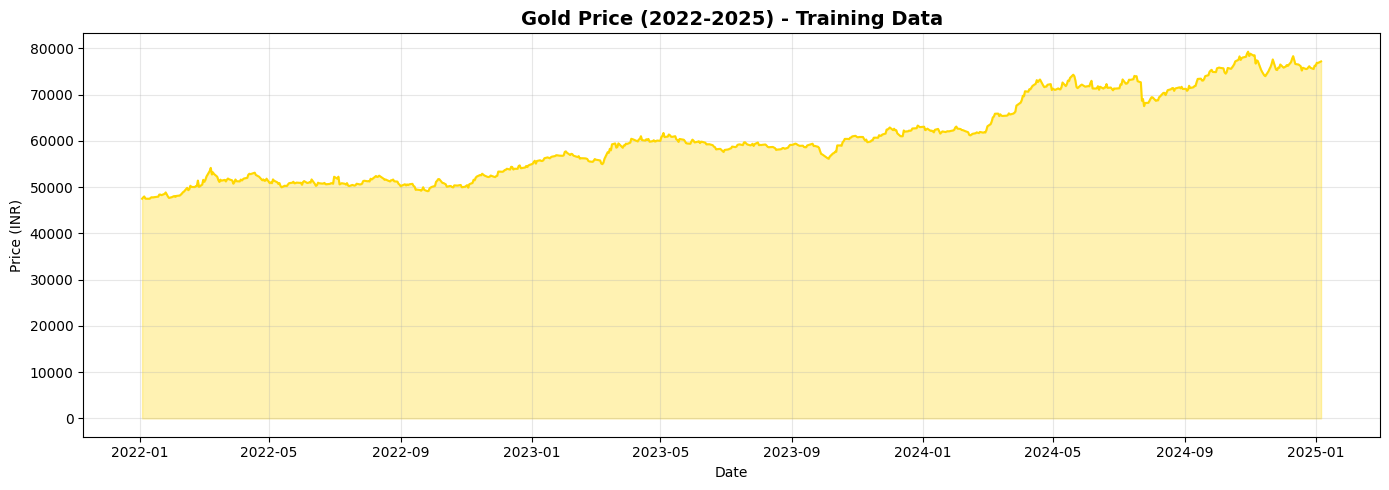


Last price: ₹77,149


In [4]:
# Visualize filtered data
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Price'], linewidth=1.5, color='gold')
plt.fill_between(df.index, df['Price'], alpha=0.3, color='gold')
plt.title(f'Gold Price ({START_YEAR}-2025) - Training Data', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nLast price: ₹{df["Price"].iloc[-1]:,.0f}')

## 🔧 Scale Data (on filtered range only)

In [5]:
# Scale on filtered data only
scaler = MinMaxScaler(feature_range=(0, 1))
all_prices = df[['Price']].values
scaler.fit(all_prices)

print(f'✅ Scaler fitted on recent data only:')
print(f'   Min: ₹{scaler.data_min_[0]:,.0f}')
print(f'   Max: ₹{scaler.data_max_[0]:,.0f}')
print(f'   (Much tighter range than ₹24k-79k!)')

scaled_data = scaler.transform(all_prices)

# Verify last price scales high
last_scaled = scaler.transform([[df['Price'].iloc[-1]]])[0, 0]
print(f'\nLast price ₹{df["Price"].iloc[-1]:,.0f} scales to: {last_scaled:.4f}')

✅ Scaler fitted on recent data only:
   Min: ₹47,471
   Max: ₹79,257
   (Much tighter range than ₹24k-79k!)

Last price ₹77,149 scales to: 0.9337


## 🧠 Build & Train Model

In [6]:
# Parameters
WINDOW_SIZE = 30   # Shorter window for less data
HORIZON = 30       # Predict 30 days

def create_sequences_multi(data, window_size, horizon):
    X, y = [], []
    for i in range(window_size, len(data) - horizon + 1):
        X.append(data[i-window_size:i, 0])
        y.append(data[i:i+horizon, 0])
    return np.array(X), np.array(y)

# Create sequences
X_all, y_all = create_sequences_multi(scaled_data, WINDOW_SIZE, HORIZON)

# Train/test split (90/10 for more training data)
split_idx = int(len(X_all) * 0.9)
X_train, y_train = X_all[:split_idx], y_all[:split_idx]
X_test, y_test = X_all[split_idx:], y_all[split_idx:]

# Reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (643, 30, 1)
y_train: (643, 30)
X_test: (72, 30, 1)


In [7]:
# Build model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(HORIZON)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,358 (122.49 KB)

 Trainable params: 31,358 (122.49 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6, verbose=1)

# Train
print('🚀 Training on recent high-price data...')
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    shuffle=False,
    verbose=1
)
print('\n✅ Training complete!')

🚀 Training on recent high-price data...
Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0406 - mae: 0.1573 - val_loss: 0.0701 - val_mae: 0.1932 - learning_rate: 0.0010
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0671 - mae: 0.2244 - val_loss: 0.0381 - val_mae: 0.1500 - learning_rate: 0.0010
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0348 - mae: 0.1545 - val_loss: 0.0105 - val_mae: 0.0784 - learning_rate: 0.0010
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - mae: 0.1019 - val_loss: 0.0285 - val_mae: 0.1451 - learning_rate: 0.0010
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0215 - mae: 0.1102 - val_loss: 0.0091 - val_mae: 0.0813 - learning_rate: 0.0010
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0196 - mae: 0.1107 - val_loss: 0.0041 - val_mae: 0.0517 - learning_rate: 0.0010
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0187 - mae: 0.1018 - val_loss: 0.0061 - val_ma

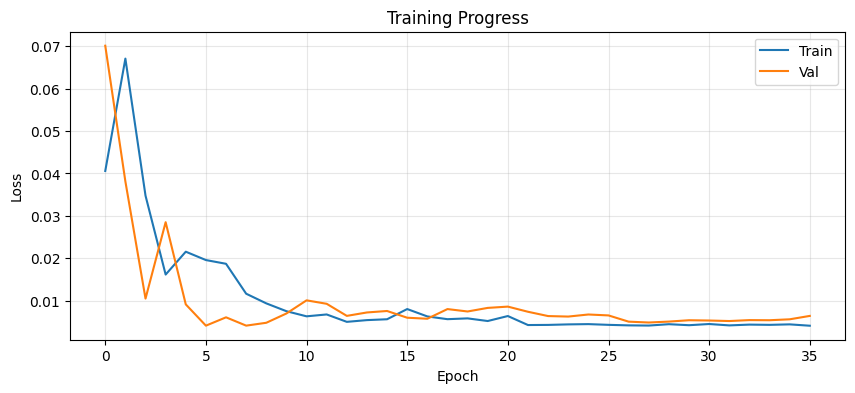

In [9]:
# Plot training
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.grid(alpha=0.3)
plt.show()

## 🔮 Forecast Functions

In [10]:
def forecast_next_n_days_direct(model, df, scaler, window_size=30, horizon=30):
    '''Forecast using multi-output model (all days at once).'''
    prices = df[['Price']].values
    scaled = scaler.transform(prices)
    
    last_window = scaled[-window_size:]
    X = last_window.reshape(1, window_size, 1)
    
    preds_scaled = model.predict(X, verbose=0)
    preds_scaled = preds_scaled.reshape(-1, 1)
    preds = scaler.inverse_transform(preds_scaled).flatten()
    
    actual_horizon = min(len(preds), horizon)
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=actual_horizon, freq='D')
    
    return pd.DataFrame({'Forecast_Price': preds[:actual_horizon]}, index=future_dates)


def forecast_next_n_days(model, df, scaler, window_size=30, n_days=30):
    '''Forecast using recursive single-step prediction.'''
    prices = df['Price'].values
    predictions = []
    
    current_window = scaler.transform(prices[-window_size:].reshape(-1, 1)).flatten()
    
    for _ in range(n_days):
        X = current_window.reshape(1, window_size, 1)
        pred_scaled = model.predict(X, verbose=0)
        
        if pred_scaled.ndim > 1 and pred_scaled.shape[1] > 1:
            pred_scaled = pred_scaled[0, 0]
        else:
            pred_scaled = pred_scaled.flatten()[0]
        
        predictions.append(pred_scaled)
        current_window = np.append(current_window[1:], pred_scaled)
    
    predictions = np.array(predictions).reshape(-1, 1)
    pred_prices = scaler.inverse_transform(predictions).flatten()
    
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_days, freq='D')
    return pd.DataFrame({'Forecast_Price': pred_prices}, index=future_dates)

print('✅ Forecast functions defined!')

✅ Forecast functions defined!


## 🔮 Generate Forecast

In [11]:
# Generate forecast
future_df = forecast_next_n_days_direct(model, df, scaler, window_size=WINDOW_SIZE, horizon=HORIZON)

print('🔮 30-Day Forecast:')
print(future_df)

# Sanity check
print('\n' + '='*50)
last_actual = df['Price'].iloc[-1]
first_pred = future_df['Forecast_Price'].iloc[0]
diff_pct = ((first_pred - last_actual) / last_actual) * 100

print(f'🔍 SANITY CHECK:')
print(f'   Last actual: ₹{last_actual:,.0f}')
print(f'   First prediction: ₹{first_pred:,.0f}')
print(f'   Difference: {diff_pct:+.2f}%')

if abs(diff_pct) < 5:
    print('   ✅ PASSED!')
elif abs(diff_pct) < 10:
    print('   ⚠️ Close but not perfect')
else:
    print('   ❌ FAILED')

🔮 30-Day Forecast:
            Forecast_Price
2025-01-07    74059.312500
2025-01-08    75101.703125
2025-01-09    74747.687500
2025-01-10    73746.632812
2025-01-11    74216.476562
2025-01-12    72985.710938
2025-01-13    73974.617188
2025-01-14    73192.468750
2025-01-15    75662.750000
2025-01-16    72729.343750
2025-01-17    71745.351562
2025-01-18    74658.414062
2025-01-19    74469.546875
2025-01-20    75304.554688
2025-01-21    75383.648438
2025-01-22    71658.304688
2025-01-23    75914.921875
2025-01-24    74999.390625
2025-01-25    75879.835938
2025-01-26    74577.382812
2025-01-27    75457.953125
2025-01-28    75501.046875
2025-01-29    73312.718750
2025-01-30    72770.953125
2025-01-31    71151.570312
2025-02-01    75276.421875
2025-02-02    73145.132812
2025-02-03    71599.078125
2025-02-04    76562.820312
2025-02-05    76096.648438

🔍 SANITY CHECK:
   Last actual: ₹77,149
   First prediction: ₹74,059
   Difference: -4.00%
   ✅ PASSED!


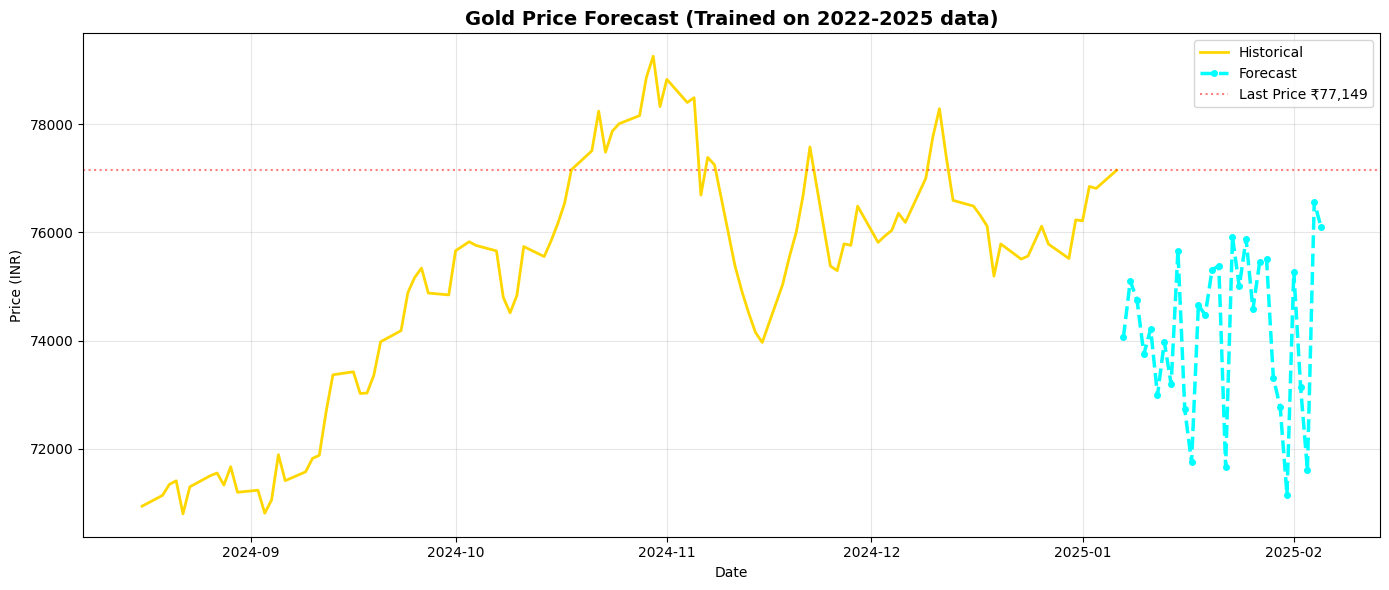


Forecast range: ₹71,152 - ₹76,563


In [12]:
# Visualize
plt.figure(figsize=(14, 6))

plt.plot(df.index[-100:], df['Price'].values[-100:], label='Historical', color='gold', linewidth=2)
plt.plot(future_df.index, future_df['Forecast_Price'], label='Forecast', color='cyan', linewidth=2.5, linestyle='--', marker='o', ms=4)
plt.axhline(y=last_actual, color='red', linestyle=':', alpha=0.5, label=f'Last Price ₹{last_actual:,.0f}')

plt.title('Gold Price Forecast (Trained on 2022-2025 data)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nForecast range: ₹{future_df["Forecast_Price"].min():,.0f} - ₹{future_df["Forecast_Price"].max():,.0f}')

## 💾 Save Model & Scaler

In [13]:
import joblib

model.save('gold_lstm_multioutput.keras')
joblib.dump(scaler, 'price_scaler.pkl')

# Also save the full dataframe for the app
df_full.to_csv('Gold Price.csv', index=False)

print('✅ Model saved: gold_lstm_multioutput.keras')
print('✅ Scaler saved: price_scaler.pkl')
print(f'   Scaler range: ₹{scaler.data_min_[0]:,.0f} - ₹{scaler.data_max_[0]:,.0f}')

✅ Model saved: gold_lstm_multioutput.keras
✅ Scaler saved: price_scaler.pkl
   Scaler range: ₹47,471 - ₹79,257


In [14]:
# Verify it works
loaded_model = tf.keras.models.load_model('gold_lstm_multioutput.keras')
loaded_scaler = joblib.load('price_scaler.pkl')

test = forecast_next_n_days_direct(loaded_model, df, loaded_scaler, WINDOW_SIZE, HORIZON)
print('✅ Verified! First 5 predictions:')
print(test.head())

print(f'\n🎉 Model is ready for your Streamlit app!')

✅ Verified! First 5 predictions:
            Forecast_Price
2025-01-07    74059.312500
2025-01-08    75101.703125
2025-01-09    74747.687500
2025-01-10    73746.632812
2025-01-11    74216.476562

🎉 Model is ready for your Streamlit app!
